In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')

In [2]:
from data import file_path

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import pickle
import pandas as pd

# umap

## raw

In [4]:
from data import RawMeanDataset
ds0 = RawMeanDataset('train')
n = 0
for x in ds0:
    n += len(x)
print(n)

ds1 = RawMeanDataset('validation')
v = 0
for x in ds1:
    v += len(x)
print(v)
print(n + v)

449434
220218
669652


In [5]:
method = 'raw'

In [6]:
f = file_path(f'umap_{method}.adata')
a = ad.read(f)
print(a)
a = a[:n].copy()
print(a)

AnnData object with n_obs × n_vars = 669652 × 39
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 449434 × 39
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [7]:
index_info_omes, index_info_begins, index_info_ends = pickle.load(open(file_path('merged_cells_info.pickle'), 'rb'))
print(index_info_ends[-1])

l = []
b = file_path(f'phenograph_{method}.hdf5')
with h5py.File(b, 'r') as f:
    for i, o in enumerate(index_info_omes):
        phenograph = f[o]['phenograph'][...].reshape((-1, 1))
        assert len(phenograph) == index_info_ends[i] - index_info_begins[i]
        l.append(phenograph)
phenographs = np.concatenate(l, axis=0)
phenographs.shape

449434


(449434, 1)

In [8]:
s = pd.Series(phenographs.flatten(), dtype='category')
print(s)
s.index = a.obs.index

a.obs['phenograph'] = s
display(a.obs)

# sc.pl.umap(a, color='phenograph')

0          6
1          3
2          3
3          1
4         22
          ..
449429    19
449430    12
449431     3
449432     2
449433    19
Length: 449434, dtype: category
Categories (58, int64): [0, 1, 2, 3, ..., 54, 55, 56, 57]


phenograph
0               6
1               3
2               3
3               1
4              22
...           ...
449429         19
449430         12
449431          3
449432          2
449433         19

[449434 rows x 1 columns]

In [9]:
aa = a[:1000, :].copy()
sc.tl.louvain(aa)
aa.obs['louvain']

0      29
1      10
2      10
3      30
4      10
       ..
995     8
996     1
997     3
998     3
999     5
Name: louvain, Length: 1000, dtype: category
Categories (104, object): ['0', '1', '2', '3', ..., '100', '101', '102', '103']

In [10]:
a

AnnData object with n_obs × n_vars = 449434 × 39
    obs: 'phenograph'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
u = a.obsm['X_umap']

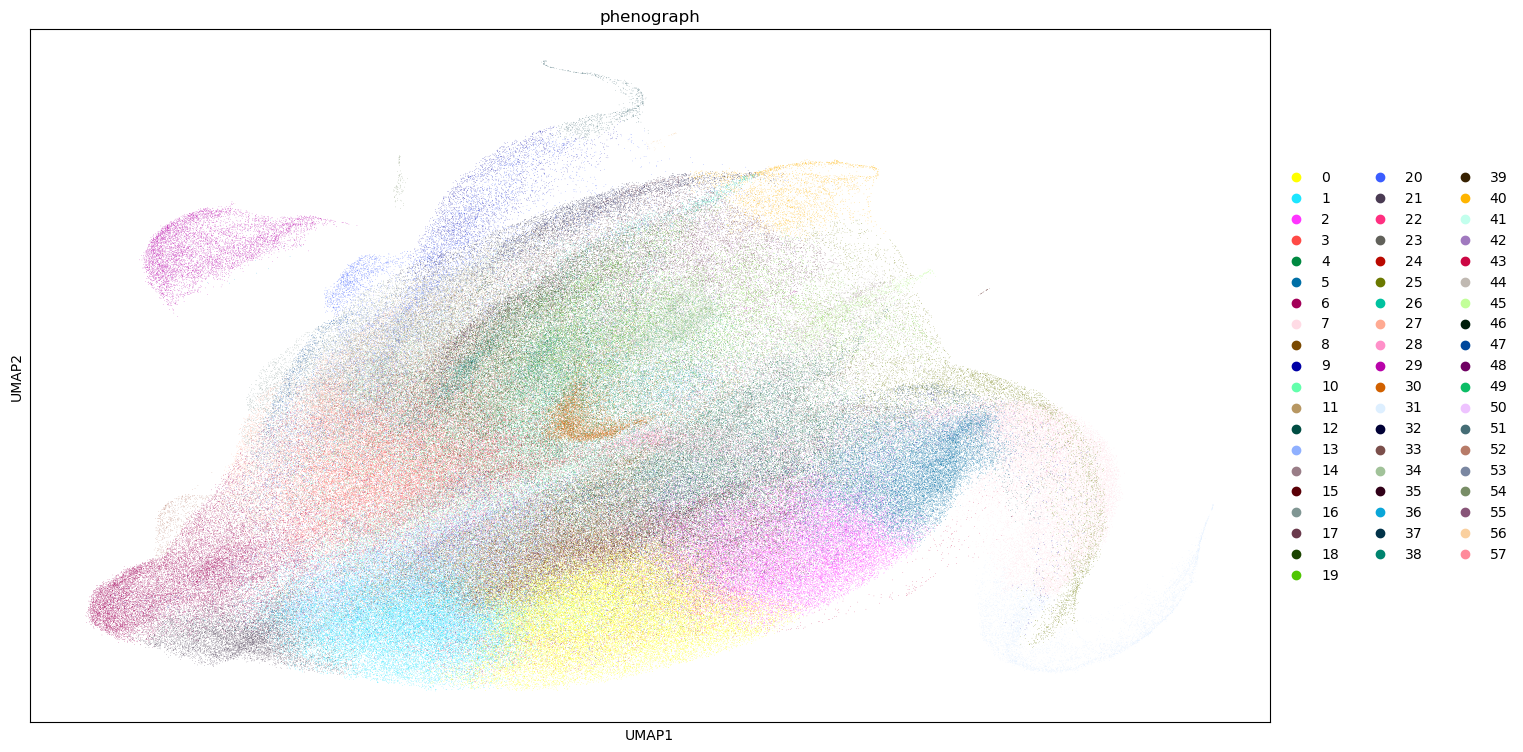

In [12]:
plt.style.use('default')
plt.figure(figsize=(16, 9))
ax = plt.gca()
sc.pl.umap(a, ax=ax, color='phenograph', size=120000 / len(a) * 2)

In [13]:
import matplotlib
plt.figure(figsize=(16, 9))
# TODO: replace with exact number of colors needed, otherwise extra colors are displayed
colors = np.repeat(np.array(sc.pl.palettes.vega_20), 3)

<Figure size 1600x900 with 0 Axes>

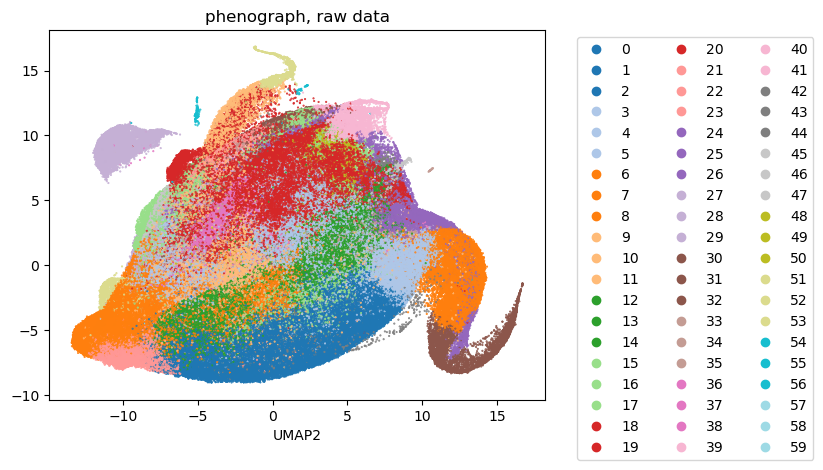

In [14]:
from matplotlib.lines import Line2D

plt.scatter(u[:, 0], u[:, 1], c=colors[a.obs['phenograph'].to_numpy()], s=120000 / len(u))
custom_lines = [Line2D([0], [0], color=c, marker='o', linestyle='none') for c in colors]
ax = plt.gca()
ax.legend(custom_lines, list(map(str, range(len(colors)))), ncol=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('phenograph, raw data')
plt.xlabel('UMAP1')
plt.xlabel('UMAP2')
plt.show()

In [15]:
%%time
print(u.shape)
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(u)
distances, indices = neighbors.kneighbors(u)

(449434, 2)
CPU times: user 25.2 s, sys: 118 ms, total: 25.3 s
Wall time: 25.4 s


In [16]:
print(distances.shape)
print(indices.shape)

(449434, 100)
(449434, 100)


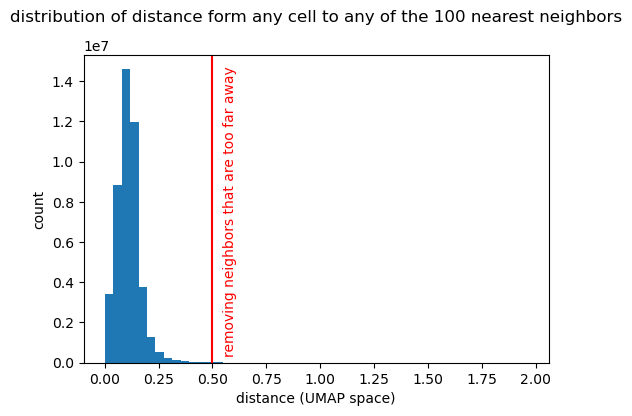

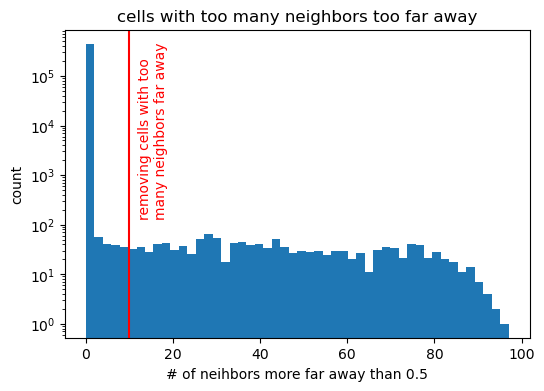

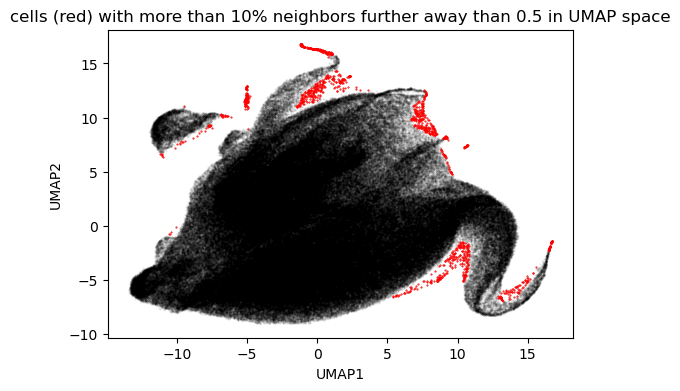

In [17]:
threshold0 = 0.5
plt.figure(figsize=(6, 4))
plt.hist(distances.flatten(), bins=50)
plt.title('distribution of distance form any cell to any of the 100 nearest neighbors', y=1.08)
plt.xlabel('distance (UMAP space)')
plt.ylabel('count')
plt.axvline(x=threshold0, c='r')
plt.text(threshold0 + 0.05, 0.75e7, f'removing neighbors that are too far away',rotation=90, c='r', verticalalignment='center', fontsize=10)
plt.show()

too_far = distances > threshold0
too_far_per_cell = np.sum(too_far, axis=1)
plt.figure(figsize=(6, 4))
plt.hist(too_far_per_cell, bins=50)
plt.yscale('log')
plt.title('cells with too many neighbors too far away')
plt.xlabel(f'# of neighbors more far away than {threshold0}')
plt.ylabel('count')
threshold1 = 10
plt.axvline(x=threshold1, c='r')
plt.text(threshold1+ 2, 8e3, f'removing cells with too\nmany neighbors far away',rotation=90, c='r', verticalalignment='center', fontsize=10)
plt.show()
bad_cells = too_far_per_cell > threshold1
filtered_indices = indices.copy().astype(np.float)
filtered_indices[too_far] = np.nan
filtered_indices[bad_cells, :] = np.nan

plt.figure(figsize=(6, 4))
plt.scatter(u[:, 0], u[:, 1], s=0.2, alpha=0.1, c='k')
plt.scatter(u[bad_cells, 0], u[bad_cells, 1], s=0.2, c='r')
plt.title(f'cells (red) with more than {threshold1}% neighbors further away than {threshold0} in UMAP space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [18]:
import bisect
index_info_omes, index_info_begins, index_info_ends = pickle.load(open(file_path('merged_cells_info.pickle'), 'rb'))

def cell_index_to_patient_index(cell_index):
    found = bisect.bisect_right(index_info_begins, cell_index) - 1
#     print(index_info_begins[found - 1], index_info_ends[found - 1])
#     print(index_info_begins[found], index_info_ends[found])
#     print(index_info_begins[found + 1], index_info_ends[found + 1])
    return found

print(list(zip(range(10), index_info_begins[:10], index_info_ends[:10])))
tests = [
    (0, 0),
    (1, 0),
    (2, 0),
    (2689, 0),
    (2690, 0),
    (2691, 1),
    (2692, 1),
    (6246, 1),
    (6247, 2)
]
for my_input, my_solution in tests:
    found = cell_index_to_patient_index(my_input)
    print(f'cell_index = {my_input}, found = {found}', end='')
    print(', passed ' if found == my_solution else f', expected {my_solution}, NOT passed')

[(0, 0, 2691), (1, 2691, 6247), (2, 6247, 9277), (3, 9277, 11993), (4, 11993, 14690), (5, 14690, 17183), (6, 17183, 20731), (7, 20731, 23361), (8, 23361, 25206), (9, 25206, 27578)]
cell_index = 0, found = 0, passed 
cell_index = 1, found = 0, passed 
cell_index = 2, found = 0, passed 
cell_index = 2689, found = 0, passed 
cell_index = 2690, found = 0, passed 
cell_index = 2691, found = 1, passed 
cell_index = 2692, found = 1, passed 
cell_index = 6246, found = 1, passed 
cell_index = 6247, found = 2, passed 


In [19]:
%%time
invalid = np.isnan(filtered_indices)
import numpy.ma as ma
y = ma.array(filtered_indices, mask=invalid)
print(y)
patient_indices = np.vectorize(cell_index_to_patient_index)(y)

[[0.0 415509.0 32246.0 ... 424540.0 368050.0 416223.0]
 [1.0 161570.0 179709.0 ... 137130.0 189038.0 249081.0]
 [2.0 140992.0 157472.0 ... 128232.0 78017.0 198780.0]
 ...
 [449431.0 71578.0 209638.0 ... 97834.0 11758.0 14874.0]
 [449432.0 353550.0 145790.0 ... 223259.0 429818.0 374678.0]
 [449433.0 411526.0 409027.0 ... 322267.0 339882.0 410721.0]]
CPU times: user 16.5 s, sys: 492 ms, total: 16.9 s
Wall time: 17 s


In [20]:
assert cell_index_to_patient_index(indices[30, 30]) == patient_indices[30, 30]
assert cell_index_to_patient_index(indices[234, 20]) == patient_indices[234, 20]

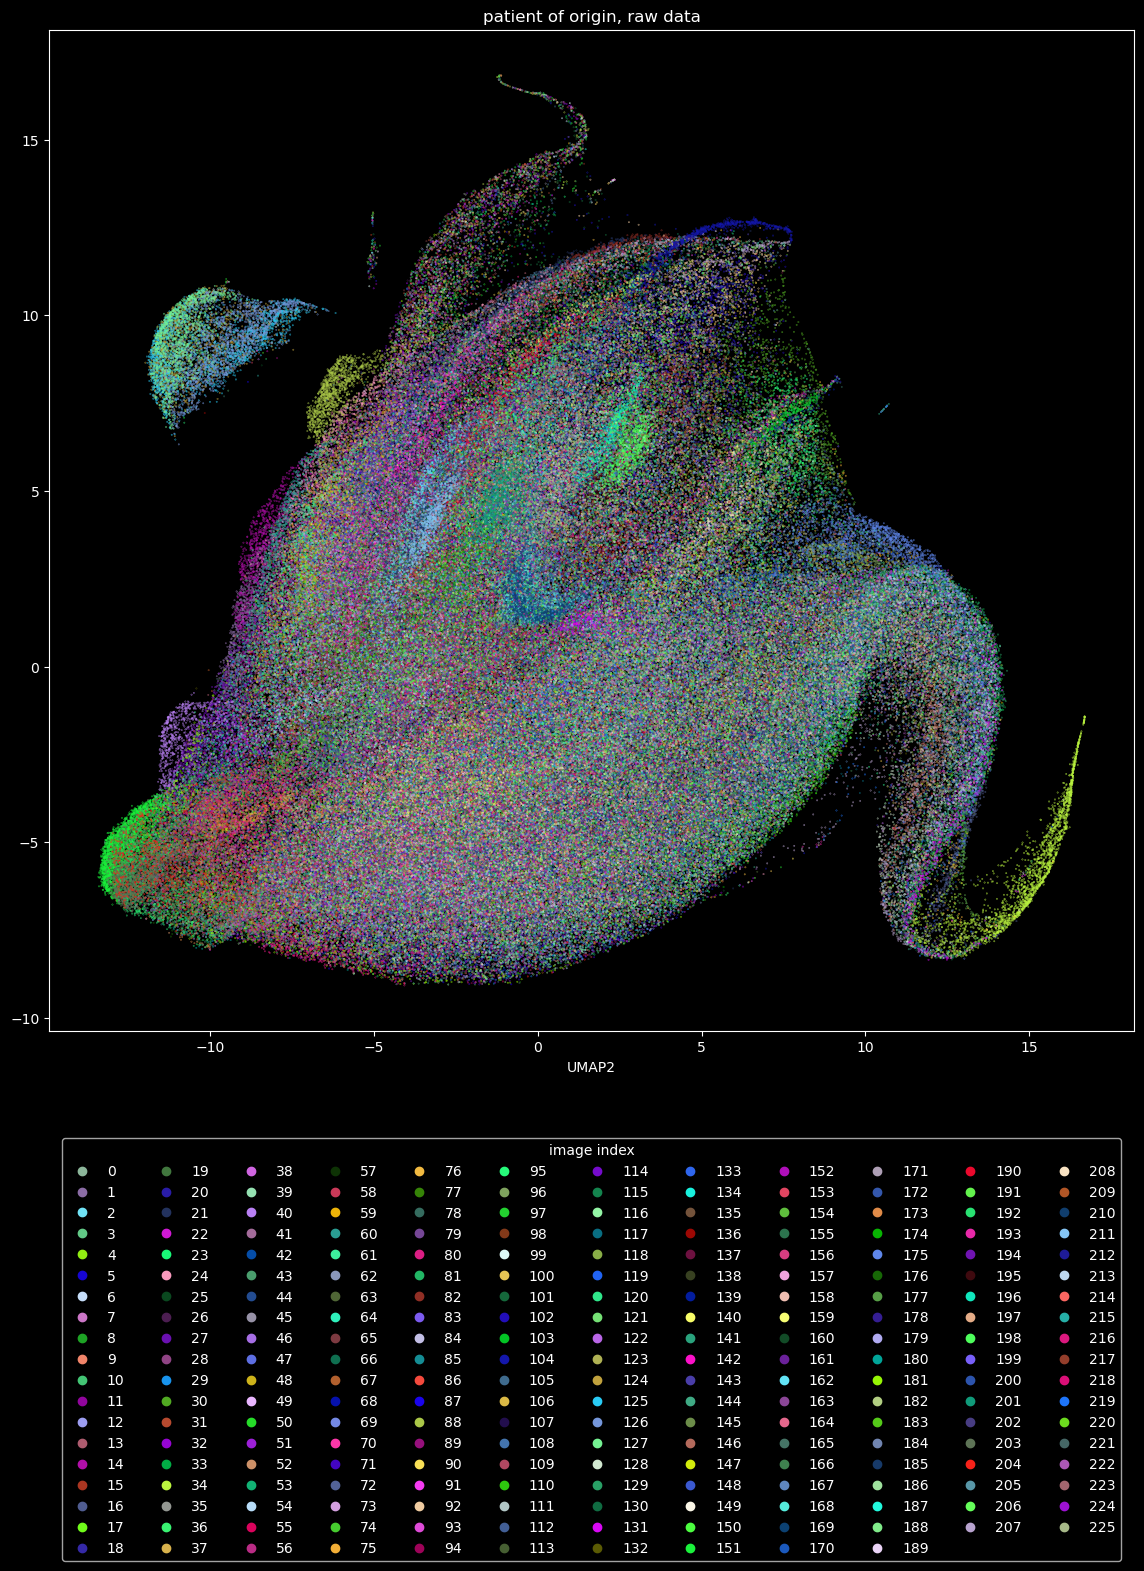

In [50]:
plt.style.use('dark_background')
np.random.seed(0)
random_patients_colors = np.random.rand(1000, 3)
patient_for_cell = np.vectorize(cell_index_to_patient_index)(np.arange(len(u)))

plt.figure(figsize=(14, 13))
plt.scatter(u[:, 0], u[:, 1], c=random_patients_colors[patient_for_cell], s=30000 / len(u))
custom_lines = [Line2D([0], [0], color=c, marker='o', linestyle='none') for c in random_patients_colors]
ax = plt.gca()
leg = ax.legend(custom_lines, list(map(str, range(len(np.unique(patient_for_cell))))), ncol=12, bbox_to_anchor=(0.5, -0.1), loc='upper center', title='image index')
plt.title('patient of origin, raw data')
plt.xlabel('UMAP1')
plt.xlabel('UMAP2')
plt.show()
plt.style.use('default')

In [21]:
%%time
print(patient_indices.shape)
print(len(index_info_omes))

a = np.apply_along_axis(lambda x: len(np.unique(x)), 1, patient_indices) 

(449434, 100)
226
CPU times: user 38.1 s, sys: 248 ms, total: 38.4 s
Wall time: 38.1 s


In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(a, bins=10)
plt.title(f'number distinct patients for 100 nearest neighbors cells and with distance < {threshold0}')
plt.xlabel('number of cells')
plt.ylabel('count')
plt.show()

In [ ]:
print(len(a))
patient_indices.shape

In [ ]:
plt.figure(figsize=(16, 9))
# plt.scatter(u[:, 0], u[:, 1], s=0.2, alpha=0.1, c='k')
x = too_far_per_cell[~bad_cells]
sizes = np.ones_like(x) * 0.01
sizes[x > 0] = 4
cmap = matplotlib.cm.viridis
# colors = np.zeros_like(x)
plt.scatter(u[~bad_cells, 0], u[~bad_cells, 1], c=too_far_per_cell[~bad_cells], s=sizes)
# plt.title(f'cells (red) with more than {threshold1 * 100}% neighbors further away than {threshold0} in UMAP space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title(f'highlighting cells with less than {threshold1}, but more than 0, distant neighbors')
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
# plt.scatter(u[:, 0], u[:, 1], s=0.2, alpha=0.1, c='k')
plt.scatter(u[~bad_cells, 0], u[~bad_cells, 1], s=0.2, c=a[~bad_cells], cmap='viridis')
plt.title(f'number distinct patients for 100 nearest neighbors cells and with distance < {threshold0}')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.show()

In [ ]:
# this is not what we want because it includes numpy.ma.core.MaskedConstant, see below, solution also below
from tqdm import tqdm
list_of_counts = []
for i in tqdm(range(len(patient_indices))):
    values, counts = np.unique(patient_indices[i, :], return_counts=True)
    list_of_counts.append(counts)

In [ ]:
m = ma.getmask(patient_indices)
# for i in range(100):
#     print(i)
#     print(np.where((m[:, i] == True) & (m[:, 1] == False)))
print(m[75708, :])
print(patient_indices[75708, :])
values, counts = np.unique(patient_indices[75708, :], return_counts=True)
print(values)
print(counts)
print(values[-1])
print(type(values[-1]))
values, counts = np.unique(ma.compressed(patient_indices[75708, :]), return_counts=True)
print(values)
print(counts)
print(np.sum(counts))

In [ ]:
# this is not what we want because it includes numpy.ma.core.MaskedConstant, see below, solution also below
from tqdm import tqdm
list_of_counts = []
for i in tqdm(range(len(patient_indices))):
    values, counts = np.unique(ma.compressed(patient_indices[i, :]), return_counts=True)
    list_of_counts.append(counts)

In [ ]:
list_of_p = []
for l in tqdm(list_of_counts):
    probability_vector = l / np.sum(l)
    list_of_p.append(probability_vector)

$$S = -\sum_{k}(p_k \log(p_k))$$

In [ ]:
import scipy.stats

list_of_s = []
for p in tqdm(list_of_p):
    s = scipy.stats.entropy(p)
    list_of_s.append(s)
entropies = np.array(list_of_s)

(449434,)


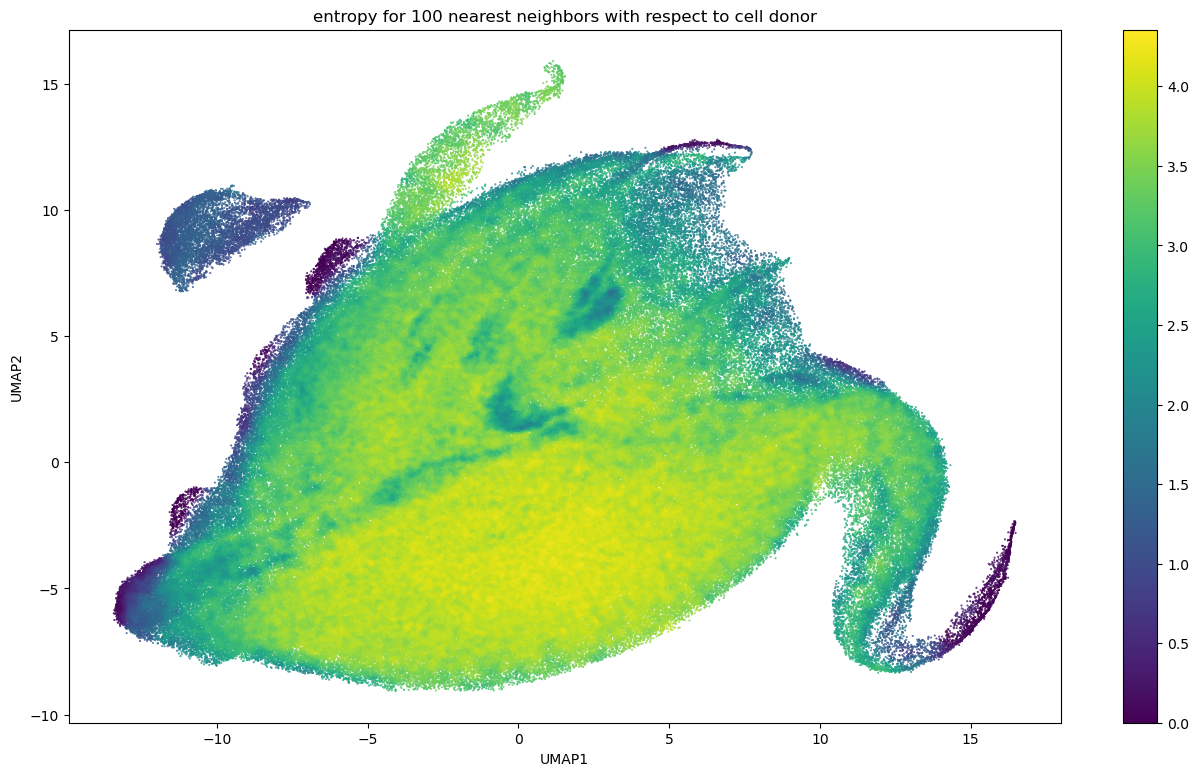

In [283]:
print(entropies.shape)
plt.figure(figsize=(16, 9))
# plt.scatter(u[:, 0], u[:, 1], s=0.2, alpha=0.1, c='k')
plt.scatter(u[~bad_cells, 0], u[~bad_cells, 1], s=0.2, c=entropies[~bad_cells], cmap='viridis')
plt.title(f'entropy for 100 nearest neighbors with respect to cell donor')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.show()

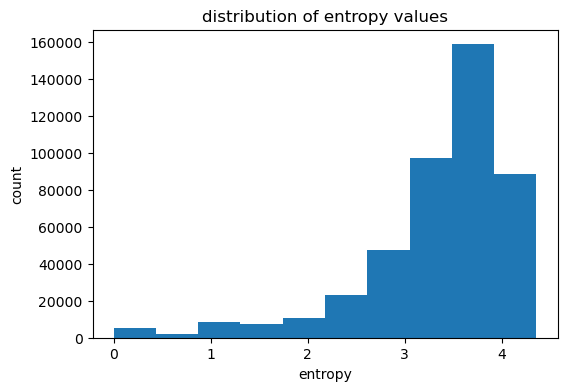

In [284]:
plt.figure(figsize=(6, 4))
plt.hist(entropies, bins=10)
plt.title(f'distribution of entropy values')
plt.xlabel('entropy')
plt.ylabel('count')
plt.show()

In [285]:
import torch

def get_filtered_labels_mapping(ome_index, ome_filename, split):
    import pickle
    f = os.path.join('data/spatial_uzh_processed/a', f'ok_cells_{split}.npy')
    d = pickle.load(open(f, 'rb'))
    list_of_cells = d['list_of_cells']
    list_of_ome_filenames = d['list_of_ome_filenames']
    list_of_ome_indices = d['list_of_ome_indices']
    list_of_cell_ids = d['list_of_cell_ids']
    cell_is_ok = d['cell_is_ok']
    begin = list_of_ome_filenames.index(ome_filename)
    end = len(list_of_ome_filenames) - list_of_ome_filenames[::-1].index(ome_filename)
    # print(list_of_ome_filenames[begin])
    # print(list_of_ome_filenames[end - 1])
    # print(list_of_ome_filenames[end])
    # print(list_of_ome_filenames[end + 1])
    oks = cell_is_ok[begin: end]
    # labels = list_of_cell_ids[begin: end]
    # print(oks.shape)
    # print(t.shape)
    l0 = np.array(list(range(np.sum(oks).item())))
    l1 = list_of_cell_ids[ome_index][oks]
    assert len(l0) == len(l1)
    d = dict(zip(l0, l1))
    return d

def colorize_masks(ome_index, ome_filename, channel_expression, masks, split, cmap_name='viridis'):
    # from data import get_filtered_labels_mapping
    d = get_filtered_labels_mapping(ome_index, ome_filename, split)
    new_masks = np.zeros((masks.shape[0], masks.shape[1], 4))
    omitted_labels = set(list(range(np.max(masks)))).difference([dd.item() for dd in d.values()]).difference({0})
    for l in omitted_labels:
        new_masks[masks == l, :] = (1., 0., 0., 1.)
    new_masks[masks == 0, :] = (0., 0., 0., 1.)
    for k, v in d.items():
        a = torch.min(channel_expression)
        b = torch.max(channel_expression)
        e = channel_expression[k].item()
        normalized_expression = (e - a) / (b - a)
        import matplotlib

        cmap = matplotlib.cm.get_cmap(cmap_name)
        ee = cmap(normalized_expression.item())
        new_masks[masks == v.item(), :] = ee
    return new_masks

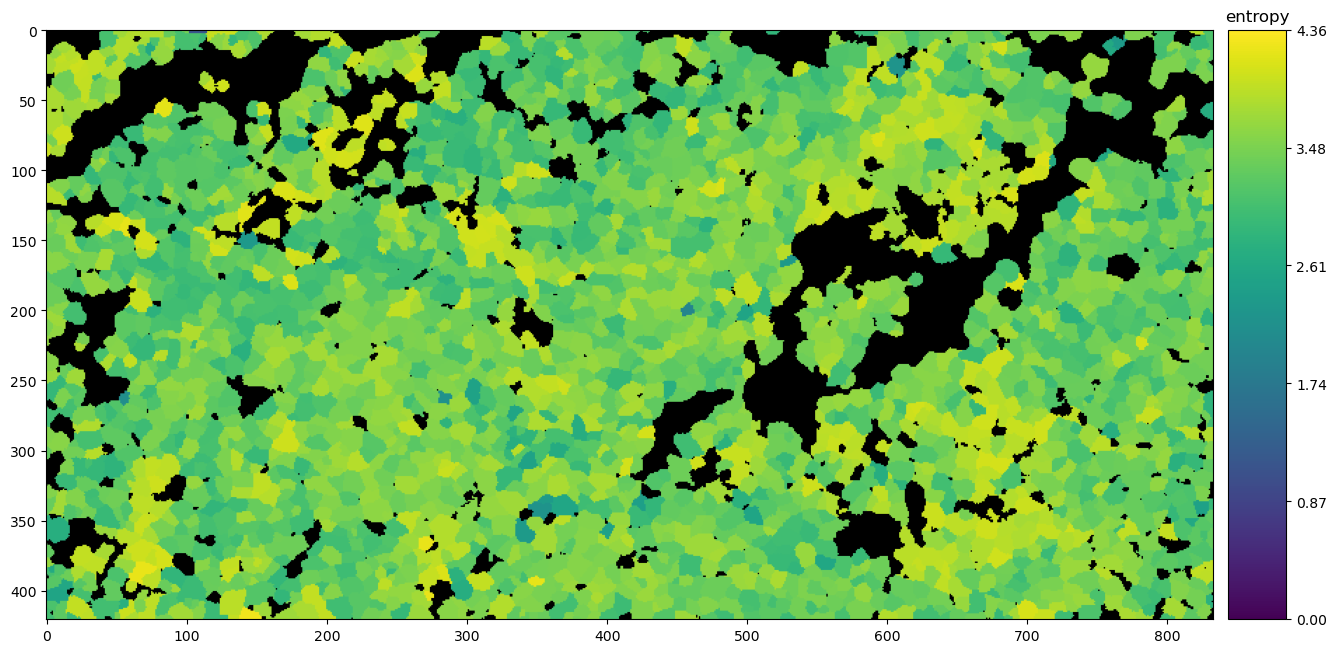

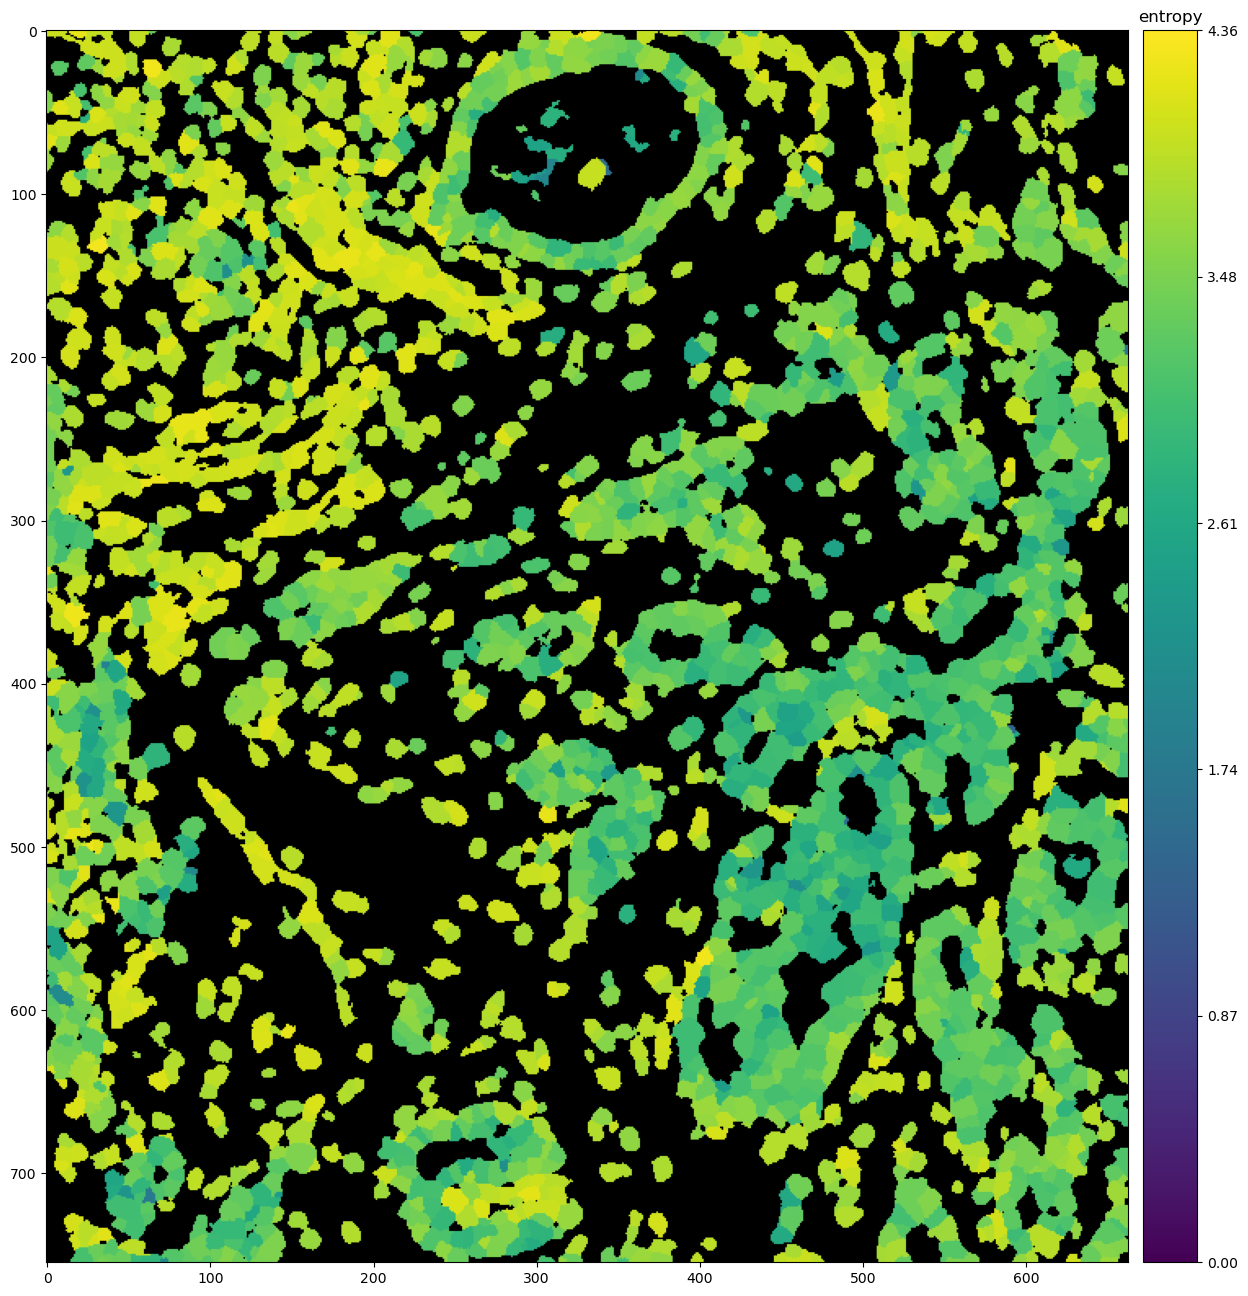

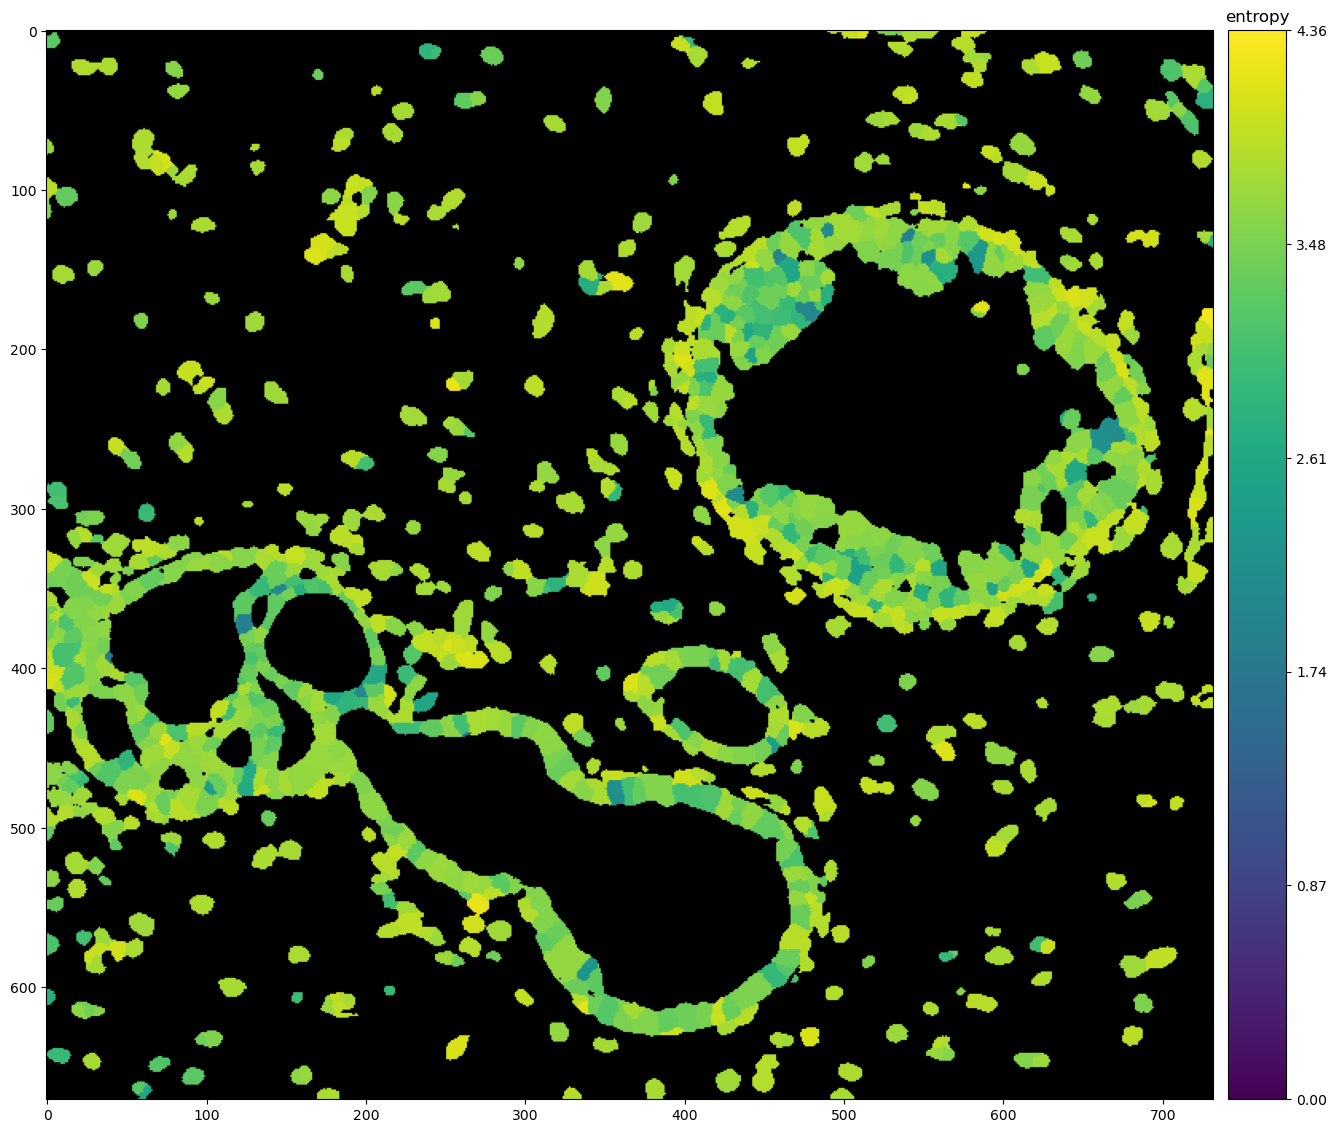

In [328]:
from data import TransformedMeanDataset, MasksDataset, OmeDataset
index_info_omes, index_info_begins, index_info_ends = pickle.load(open(file_path('merged_cells_info.pickle'), 'rb'))

ds = OmeDataset('train')
ds_train = TransformedMeanDataset('train')
masks_ds_train = MasksDataset('train')

for ome_index in [0, 7, 19]:
    ome_filename = ds_train.filenames[ome_index]
    begin = index_info_begins[ome_index]
    end = index_info_ends[ome_index]
    ome_entropies = entropies[begin: end]
#     max_ome_entropy = np.max(ome_entropies)
#     min_ome_entropy = np.min(ome_entropies)
    max_ome_entropy = np.max(entropies)
    min_ome_entropy = np.min(entropies)
    ome_entropies = (ome_entropies - min_ome_entropy) / (max_ome_entropy - min_ome_entropy)
    
#     from sklearn.decomposition import PCA
#     reducer = PCA(3)
#     pca = reducer.fit_transform(expression.numpy())
#     mins = np.min(pca, axis=0)
#     maxs = np.max(pca, axis=0)
#     pca = (pca - mins) / (maxs - mins)
#     ones = np.ones(len(pca)).reshape((-1, 1))
#     pca = np.concatenate([pca, ones], axis=1)
    
    masks = masks_ds_train[ome_index]
    
    d = get_filtered_labels_mapping(ome_index, ome_filename, 'train')
    cmap = matplotlib.cm.viridis
    
    new_masks = np.zeros((masks.shape[0], masks.shape[1], 4))
    omitted_labels = set(list(range(np.max(masks)))).difference([dd.item() for dd in d.values()]).difference({0})
    for l in omitted_labels:
        new_masks[masks == l, :] = (0., 0., 0., 1.)
    new_masks[masks == 0, :] = (0., 0., 0., 1.)
    for k, v in d.items():
        a = list(cmap(ome_entropies[k])[:3]) + [1.]
        color = np.array(a)
        new_masks[masks == v.item(), :] = color
    
#     channel_expression = expression[:, 0]
#     colorized_masks = colorize_masks(ome_index, ome_filename, channel_expression, masks, split='train', cmap_name='viridis')
#     plt.figure(figsize=(9, 9))    
#     plt.imshow(colorized_masks)
#     plt.title(f'ome_index = {ome_index}')
#     plt.show()
    
    fig = plt.figure(figsize=(16, 16))    
    im = plt.imshow(new_masks)
    
#     cax = fig.add_axes([right+0.035, bottom, 0.035, top-bottom])
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    cbar = plt.colorbar(im, cax=cax)
#     cbar = plt.colorbar()
#     cbar = plt.colorbar(orientation='horizontal')
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f'{x:.2f}' for x in np.linspace(min_ome_entropy, max_ome_entropy, 6)])
    cbar.ax.set_title('entropy')
#     plt.title(f'ome_index = {ome_index}')
#     plt.title(f'3-dim pca of transformed cell-level data, mapped into the RGB space')
    plt.show()
    
#     o = ds.filenames[ome_index]
#     x = ds[ome_index].numpy()
    
#     z = scale(o, x)
#     a, b = z.shape[:2]
#     z = z.reshape(-1, 39)
#     z_pca = reducer.fit_transform(z)
#     z_mins = np.min(z_pca, axis=0)
#     z_maxs = np.max(z_pca, axis=0)
#     z_pca = (z_pca - z_mins) / (z_maxs - z_mins)
#     z_pca.shape = (a, b, 3)
    
#     plt.figure(figsize=(16, 16))
#     plt.imshow(z_pca)
#     plt.title('3-dim PCA of transformed data, mapped into the RGB space')
#     plt.show()

list

## transformed

In [10]:
method = 'transformed'

## vae mu

In [12]:
method = 'vae_mu'

# slides

## raw

In [9]:
method = 'raw'

## transformed

In [11]:
method = 'transformed'

## vae mu

In [13]:
method = 'vae_mu'